In [1]:
%matplotlib inline


In [2]:
import os
os.chdir('..')


Understand Spatial Patterns:

Where are the flood-prone areas?
How do river levels and weather stations relate spatially?
Are there any spatial clusters or anomalies in your data?
Generate Features for Modeling:

Calculate distances between river gauges and weather stations.
Identify the proximity of river gauges to potential flooding locations.
Add geographic context (e.g., elevation, land use) to the data.
Prepare Data for Visualization:

Create maps that clearly communicate spatial patterns in river levels and flood risks.
Identify missing or outlier data visually.
Questions to Address
Spatial Relationships:

How far are river gauges from weather stations?
Which weather stations are closest to flood-prone areas?
Flood Risk Assessment:

Are certain river gauges consistently associated with high flood levels?
Do specific areas experience repeated floods (e.g., spatial clustering)?
Impact of Weather:

How does proximity to weather stations correlate with river gauge measurements?
Are rainfall patterns spatially aligned with rising water levels?
Spatial Data Quality:

Are there gaps in spatial coverage (e.g., areas with no nearby weather stations)?
Are there any duplicate or misaligned points?

# Flood prediction Cornwall - Geospatial Analysis Experiment

- Goal: learn and apply GIS to my existing project, seeing if I can draw any interesting insights and learning libraries required for Urban Intelligence Junior DS

In [3]:
from src.data_preprocessing import load_all_river_gauge_csvs, load_all_weather_station_csvs
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [4]:
gauges = pd.read_csv('data/river_data/river_station_info_cornwall.csv', usecols=['id', 'name', 'longitude', 'latitude'])

In [5]:
gauges

,id,name,latitude,longitude
0,380,Denby,50.479652,-4.795633
1,382,Helebridge,50.806427,-4.536459
2,384,Bush,50.844487,-4.509160
3,386,Padstow,50.541745,-4.936932
4,387,Penvose,50.566819,-4.750514
5,391,Wadebridge,50.516704,-4.834983
6,393,De Lank,50.558805,-4.637791
7,394,Gwills,50.393216,-5.056212
8,395,Slaughterbridge,50.640434,-4.675177
9,397,Sladesbridge,50.509313,-4.804805


In [6]:
# Define the directory with weather station CSVs
weather_data_directory = 'data/weather_data'

# Create a list to store weather station details, including station id, name, latitude, and longitude
weather_station_details = []

# Iterate through each file in the weather data directory
for file in os.listdir(weather_data_directory):
    file_path = os.path.join(weather_data_directory, file)
    
    # Only process CSV files
    if file.endswith('.csv'):
        try:
            # Read a small sample from each CSV to get the weather station coordinates
            data = pd.read_csv(file_path, nrows=1)  # Only read the first row
            
            # Extract the weather station coordinates if columns are present
            if 'weather_station_latitude' in data.columns and 'weather_station_longitude' in data.columns:
                latitude = data['weather_station_latitude'].iloc[0]
                longitude = data['weather_station_longitude'].iloc[0]
                
                # Extract river gauge station ID and weather station name from the filename
                # Filename format assumed: Denby_380_nearest_weather_station_openmeteo.csv
                parts = file.split('_')
                station_name = parts[0]  # 'Denby'
                gauge_id = parts[1]  # '380'
                
                # Append extracted details to the list
                weather_station_details.append({
                    'gauge_id': gauge_id,
                    'station_name': station_name,
                    'latitude': latitude,
                    'longitude': longitude
                })
        
        except Exception as e:
            print(f"Could not process file {file}: {e}")

# Convert the list of station details to a DataFrame for easier plotting and inspection
weather_station_details_df = pd.DataFrame(weather_station_details)




In [7]:
weather_station_details_df

,gauge_id,station_name,latitude,longitude
0,398,Woolstone Mill,50.790859,-4.483978
1,17891,BODMIN DUNMERE,50.439365,-4.761902
2,384,Bush,50.861156,-4.491974
3,382,Helebridge,50.790859,-4.483978
4,400,Bodmin Band Club,50.439365,-4.761902
5,391,Wadebridge,50.509663,-4.929321
6,375,St Ives Tide,50.228470,-5.368439
7,393,De Lank,50.579964,-4.619446
8,370,Boscadjack,50.158169,-5.201416
9,361,Loe Pool,50.087872,-5.192322


In [8]:
gauges['id'] = gauges['id'].astype('str')



In [9]:
merged = pd.merge(gauges, weather_station_details_df, left_on='id', right_on='gauge_id')


In [10]:
merged.drop('id', axis=1, inplace=True)

In [11]:
merged.rename(columns={'latitude_x': 'latitude_gauge', 'longitude_x': 'longitude_gauge', 'latitude_y': 'latitude_weather', 'longitude_y': 'longitude_weather'}, inplace=True)

In [12]:
merged.columns

Index(['name', 'latitude_gauge', 'longitude_gauge', 'gauge_id', 'station_name',
       'latitude_weather', 'longitude_weather'],
      dtype='object')

In [13]:
import geopandas as gpd
from shapely.geometry import Point

# Create geometry columns for gauges and weather stations
merged['geometry_gauge'] = merged.apply(lambda row: Point(row['longitude_gauge'], row['latitude_gauge']), axis=1)
merged['geometry_station'] = merged.apply(lambda row: Point(row['longitude_weather'], row['latitude_weather']), axis=1)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(merged, geometry='geometry_gauge', crs="EPSG:4326")



ONS : Local Authority Districts (December 2021) UK BUC data

In [14]:
# Load Cornwall boundary shapefile or GeoJSON
cornwall_boundary = gpd.read_file('/Users/antonfreidin/Downloads/Local_Authority_Districts_December_2021_UK_BGC_2022_-6905220656906535518/LAD_DEC_2021_UK_BGC.shp')  # Replace with the file path

# Ensure CRS matches the weather station GeoDataFrame
cornwall_boundary = cornwall_boundary.to_crs(gdf.crs)


cornwall_boundary = cornwall_boundary[cornwall_boundary['LAD21NM'] == 'Cornwall']

print(cornwall_boundary)


      LAD21CD   LAD21NM LAD21NMW   BNG_E  BNG_N     LONG      LAT  \
48  E06000052  Cornwall     None  212497  64493 -4.64254  50.4502   

                                GlobalID  \
48  f4c0da16-7328-4bb4-89cd-8f8ce2e5e685   

                                             geometry  
48  MULTIPOLYGON (((-5.22637 49.97244, -5.22581 49...  


## Buffer Zone Analysis

In [15]:
from shapely.geometry import Point

# Create geometry columns
merged['geometry_gauge'] = merged.apply(lambda row: Point(row['longitude_gauge'], row['latitude_gauge']), axis=1)
merged['geometry_station'] = merged.apply(lambda row: Point(row['longitude_weather'], row['latitude_weather']), axis=1)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(merged, geometry='geometry_gauge', crs="EPSG:4326")



<Axes: >

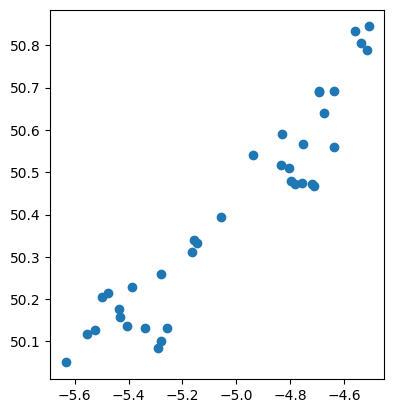

In [16]:
gdf.plot()

In [17]:
gdf

,name,latitude_gauge,longitude_gauge,gauge_id,station_name,latitude_weather,longitude_weather,geometry_gauge,geometry_station
0,Denby,50.479652,-4.795633,380,Denby,50.509663,-4.929321,POINT (-4.79563 50.47965),POINT (-4.9293212890625 50.50966262817383)
1,Helebridge,50.806427,-4.536459,382,Helebridge,50.790859,-4.483978,POINT (-4.53646 50.80643),POINT (-4.483978271484375 50.79085922241211)
2,Bush,50.844487,-4.509160,384,Bush,50.861156,-4.491974,POINT (-4.50916 50.84449),POINT (-4.491973876953125 50.86115646362305)
3,Padstow,50.541745,-4.936932,386,Padstow,50.509663,-4.929321,POINT (-4.93693 50.54175),POINT (-4.9293212890625 50.50966262817383)
4,Penvose,50.566819,-4.750514,387,Penvose,50.579964,-4.778748,POINT (-4.75051 50.56682),POINT (-4.77874755859375 50.57996368408203)
5,Wadebridge,50.516704,-4.834983,391,Wadebridge,50.509663,-4.929321,POINT (-4.83498 50.5167),POINT (-4.9293212890625 50.50966262817383)
6,De Lank,50.558805,-4.637791,393,De Lank,50.579964,-4.619446,POINT (-4.63779 50.55881),POINT (-4.61944580078125 50.57996368408203)
7,Gwills,50.393216,-5.056212,394,Gwills,50.369068,-5.070404,POINT (-5.05621 50.39322),POINT (-5.070404052734375 50.36906814575195)
8,Slaughterbridge,50.640434,-4.675177,395,Slaughterbridge,50.650261,-4.627655,POINT (-4.67518 50.64043),POINT (-4.627655029296875 50.65026092529297)
9,Sladesbridge,50.509313,-4.804805,397,Sladesbridge,50.509663,-4.929321,POINT (-4.8048 50.50931),POINT (-4.9293212890625 50.50966262817383)


In [18]:
# Check active geometry and CRS
print(gdf.geometry.name)  # Should be 'geometry_gauge'
print(gdf.crs)  # Should be 'EPSG:4326'

# If not set, explicitly set the geometry and CRS
gdf = gdf.set_geometry("geometry_gauge")
gdf = gdf.set_crs("EPSG:4326")


geometry_gauge
EPSG:4326


In [19]:
# Reproject to EPSG:3857 for buffering
gdf_projected = gdf.to_crs("EPSG:3857")


In [20]:
# Create a 10 km buffer (10,000 meters)
gdf_projected["buffer_10km"] = gdf_projected.geometry.buffer(10000)


In [23]:
# Reproject back to EPSG:4326
gdf_with_buffers = gdf_projected.to_crs("EPSG:4326")
gdf_with_buffers = gdf_with_buffers.set_geometry("buffer_10km")



In [27]:
print(gdf_with_buffers.crs)  # Should output 'EPSG:4326'

# Transform CRS to EPSG:4326 (WGS 84, for latitude/longitude)
gdf_with_buffers = gdf_with_buffers.to_crs("EPSG:4326")



EPSG:3857


/var/folders/4n/18wn5fm9177dpn28hhj4f8w00000gn/T/ipykernel_69645/2541210711.py:14: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


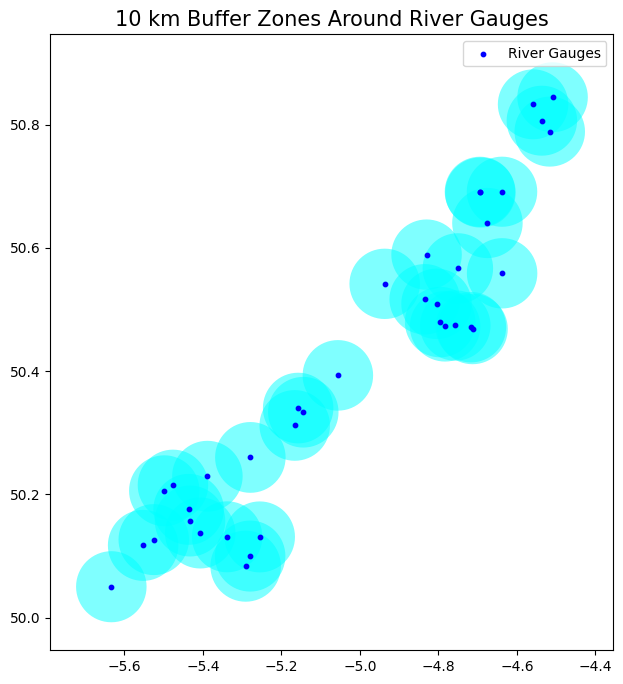

In [28]:

import matplotlib.pyplot as plt

# Plot buffers and gauges
fig, ax = plt.subplots(figsize=(10, 8))

# Plot buffer zones
gdf_with_buffers.set_geometry("buffer_10km").plot(ax=ax, color="cyan", alpha=0.5, label="10 km Buffers")

# Plot river gauges
gdf_with_buffers.set_geometry("geometry_gauge").plot(ax=ax, color="blue", markersize=10, label="River Gauges")

# Add title and legend
ax.set_title("10 km Buffer Zones Around River Gauges", fontsize=15)
ax.legend()
plt.show()


/var/folders/4n/18wn5fm9177dpn28hhj4f8w00000gn/T/ipykernel_69645/1518876319.py:15: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


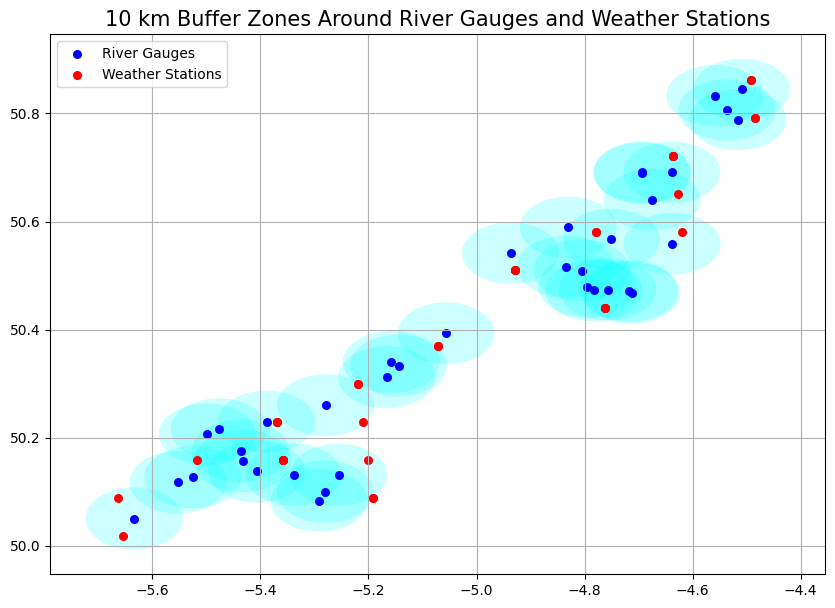

In [33]:
# Plot river gauges, weather stations, and buffer zones
fig, ax = plt.subplots(figsize=(10, 8))

# Plot buffer zones
gdf_with_buffers.set_geometry("buffer_10km").plot(ax=ax, color="cyan", alpha=0.2, label="10 km Buffers")

# Plot river gauges
gdf_with_buffers.set_geometry("geometry_gauge").plot(ax=ax, color="blue", markersize=30, label="River Gauges")

# Plot weather stations
gdf_with_buffers.set_geometry("geometry_station").plot(ax=ax, color="red", markersize=30, label="Weather Stations")

# Add title, legend, and grid
ax.set_title("10 km Buffer Zones Around River Gauges and Weather Stations", fontsize=15)
ax.legend()
ax.grid(True)


# Display the plot
plt.show()


In [40]:
# cornwall boundary

cornwall_boundary

,LAD21CD,LAD21NM,LAD21NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
48,E06000052,Cornwall,None,212497,64493,-4.64254,50.4502,f4c0da16-7328-4bb4-89cd-8f8ce2e5e685,"MULTIPOLYGON (((-5.22637 49.97244, -5.22581 49..."


In [41]:
# Reproject Cornwall boundary to match the GeoDataFrame
cornwall_boundary = cornwall_boundary.to_crs(gdf_with_buffers.crs)


/var/folders/4n/18wn5fm9177dpn28hhj4f8w00000gn/T/ipykernel_69645/1110573446.py:18: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="upper left")


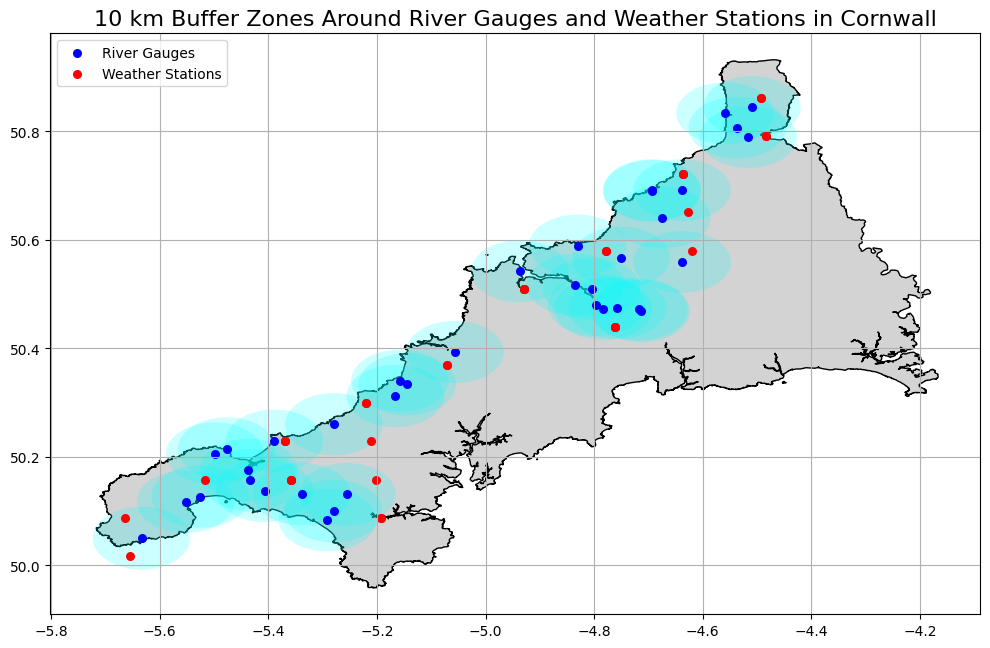

In [ ]:
# Plot the map with Cornwall boundary
fig, ax = plt.subplots(figsize=(12, 10))

# Plot Cornwall boundary
cornwall_boundary.plot(ax=ax, color="lightgrey", edgecolor="black", label="Cornwall Boundary")

# Plot buffer zones with transparency
gdf_with_buffers.set_geometry("buffer_10km").plot(ax=ax, color="cyan", alpha=0.2, label="10 km Buffers")

# Plot river gauges
gdf_with_buffers.set_geometry("geometry_gauge").plot(ax=ax, color="blue", markersize=30, label="River Gauges")

# Plot weather stations
gdf_with_buffers.set_geometry("geometry_station").plot(ax=ax, color="red", markersize=30, label="Weather Stations")


ax.set_title("10 km Buffer Zones Around River Gauges and Weather Stations in Cornwall", fontsize=16)
ax.legend(loc="upper left")
ax.grid(True)

plt.show()


## NEXT : add flood zones / load into QGIS